<a href="https://colab.research.google.com/github/NethmiAmasha/Edge-Detection-with-Mamba/blob/main/EDMB_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm scipy

In [3]:
!git clone https://github.com/BIDS/BSDS500.git

Cloning into 'BSDS500'...
remote: Enumerating objects: 2380, done.
remote: Total 2380 (delta 0), reused 0 (delta 0), pack-reused 2380 (from 1)
Receiving objects: 100% (2380/2380), 155.21 MiB | 30.29 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (2268/2268), done.


Loading the training dataset...
Dataset loaded. Number of training images: 200

Sample image tensor shape: torch.Size([3, 321, 481])
Sample ground truth tensor shape: torch.Size([1, 321, 481])


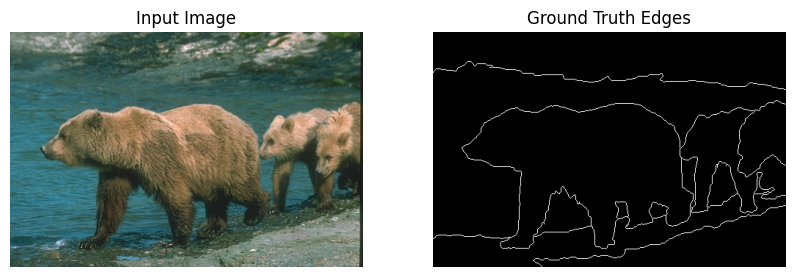

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

class BSDS500Dataset(Dataset):
    """
    A PyTorch Dataset class to load the BSDS500 dataset from the cloned repo. (Corrected)
    """
    def __init__(self, root_dir, split='train'):
        self.root_dir = root_dir
        self.split = split
        self.images_dir = os.path.join(root_dir, 'BSDS500/data/images', split)
        self.gt_dir = os.path.join(root_dir, 'BSDS500/data/groundTruth', split)

        self.image_files = sorted([f for f in os.listdir(self.images_dir) if f.endswith('.jpg')])
        self.gt_files = sorted([f for f in os.listdir(self.gt_dir) if f.endswith('.mat')])

        self.transform = transforms.Compose([
            transforms.Resize((321, 481)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.target_transform = transforms.Compose([
            transforms.Resize((321, 481), interpolation=Image.NEAREST),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        gt_path = os.path.join(self.gt_dir, self.gt_files[idx])
        mat = sio.loadmat(gt_path)

        # --- THIS IS THE CORRECTED LINE ---
        # We access the first annotation [0, 0] and then its 'Boundaries' field.
        ground_truth_mask = mat['groundTruth'][0, 0]['Boundaries'][0, 0]
        # --------------------------------

        gt_image = Image.fromarray(ground_truth_mask)

        image_tensor = self.transform(image)
        gt_tensor = torch.from_numpy(np.array(self.target_transform(gt_image))).float().unsqueeze(0)

        return image_tensor, gt_tensor

# --- Let's test it again! ---
print("Loading the training dataset...")
train_dataset = BSDS500Dataset(root_dir='BSDS500', split='train')
print(f"Dataset loaded. Number of training images: {len(train_dataset)}")

# Get one sample
image_tensor, gt_tensor = train_dataset[0]

print(f"\nSample image tensor shape: {image_tensor.shape}")
print(f"Sample ground truth tensor shape: {gt_tensor.shape}")

# Visualize the sample
unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
img_for_display = unnormalize(image_tensor)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_for_display.permute(1, 2, 0))
ax[0].set_title('Input Image')
ax[0].axis('off')

ax[1].imshow(gt_tensor.squeeze(), cmap='gray')
ax[1].set_title('Ground Truth Edges')
ax[1].axis('off')

plt.show()